In [163]:
# import libraries
import os, zipfile
import numpy as np
import pandas as pd
import nltk

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras import regularizers

### Read in Data

In [20]:
# read in data
url = 'https://raw.githubusercontent.com/ziwei-z/w266-project/main/data/en-annotated.tsv'
data = pd.read_csv(url, sep='\t', header=None, names=['sentence', 'label_raw'])

# make flag for each emotion
emotions = ['anger', 'anticipation', 'digust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
i = 1
for emo in emotions:
    data[emo] = data.label_raw.str.contains(str(i))*1
    i += 1

data['label'] = [y[2:].astype('float32') for (x, y) in enumerate(data.values)]
data.head()

,sentence,label_raw,anger,anticipation,digust,fear,joy,sadness,surprise,trust,label
0,", ...",1,1,0,0,0,0,0,0,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,!,"1, 4, 7",1,0,0,1,0,0,1,0,"[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]"
2,... And I don't think we need to discuss the T...,"8, 1",1,0,0,0,0,0,0,1,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
3,* So get up out of your bed,1,1,0,0,0,0,0,0,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,A confession that you hired [PERSON] ... and a...,"1, 6",1,0,0,0,0,1,0,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"


In [22]:
# split test & train
train_in, test_in, train_labels, test_labels = train_test_split(data['sentence'], data['label'], test_size = 0.2, random_state=13)
print('Train dataset shape: ', train_in.shape)
print('Test dataset shape: ', test_in.shape)

Train dataset shape:  (14022,)
Test dataset shape:  (3506,)


In [23]:
# Split to create Dev set
train_in, dev_in, train_labels, dev_labels = train_test_split(train_in, train_labels,
                                                              test_size = 0.25, random_state=13)
print('Train dataset shape: ', train_in.shape)
print('Dev dataset shape: ', dev_in.shape)

Train dataset shape:  (10516,)
Dev dataset shape:  (3506,)


In [24]:
train_labels = np.concatenate([[train_labels.iloc[x] for x in list(range(len(train_labels)))]])
test_labels = np.concatenate([[test_labels.iloc[x] for x in list(range(len(test_labels)))]])
dev_labels = np.concatenate([[dev_labels.iloc[x] for x in list(range(len(dev_labels)))]])

In [52]:
test_in

12272                                What about us ?
14401    I mean that all my life I've been nothing .
16685                  I'll break it to her gently .
17396              You know what I'm talking about .
5364                          Look , it's [PERSON] !
                            ...                     
9360                             In here ! Quickly !
7684                               Who dares to ....
8597       First , I would like to take off my hat .
3834               Get going , [PERSON] ! [PERSON] !
8503                                       Correct ?
Name: sentence, Length: 3506, dtype: object

### Baseline model - CNN

#### tokenize and embed sentences
- Using Glove

In [54]:
# Process sentences 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# tun into tokens
# max len 
max_len = train_in.str.len().max()
if test_in.str.len().max() > max_len: max_len = test_in.str.len().max()
print('max sentence length in train and test =', max_len)

# initialize tokenizer 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_in)

# convert to sequences and pad
train_sequences = tokenizer.texts_to_sequences(train_in)
dev_sequences = tokenizer.texts_to_sequences(dev_in)
test_sequences = tokenizer.texts_to_sequences(test_in)
padding_type = "post"
truncate_type = "pre"
# use 100 for now
max_len_touse = 100
train_padded = pad_sequences(train_sequences,maxlen=max_len_touse, padding=padding_type, truncating=truncate_type)
dev_padded = pad_sequences(dev_sequences,maxlen=max_len_touse, padding=padding_type, truncating=truncate_type)
test_padded = pad_sequences(test_sequences,maxlen=max_len_touse, padding=padding_type, truncating=truncate_type)

max sentence length in train and test = 299


In [27]:
dev_labels

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [57]:
# download Glove model
# based on https://cnvrg.io/cnn-sentence-classification/
import wget
if not os.path.isdir("data"):
    os.makedirs("data")
url = "http://nlp.stanford.edu/data/glove.6B.zip"
wget.download(url, out="data")

'data/glove.6B (1).zip'

In [58]:
with zipfile.ZipFile('data/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('data/glove')

In [59]:
embeddings_index = {}
f = open('data/glove/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [60]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, max_len_touse))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros
        embedding_matrix[i] = embedding_vector

# Train model
## CNN

- First attempt: based on  https://cnvrg.io/cnn-sentence-classification/
        Did not perform better than most common class (label 0 at 21.2%)... :(

In [28]:
# define kera embedding layer
embedding_layer = keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                            output_dim=max_len_touse,
                            weights=[embedding_matrix],
                            input_length=max_len_touse,
                            trainable=False)

In [29]:
# model - option 1 
model_test = keras.models.Sequential([
    embedding_layer,
  keras.layers.Conv1D(128, 5, activation='relu'),
    keras.layers.GlobalMaxPooling1D(),
  keras.layers.Dense(10, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')
])

In [13]:
# train model 
model_test.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model_test.fit(train_padded, train_labels, epochs=10)

Epoch 1/10
329/329 [==============================] - 2s 6ms/step - loss: 3.7166e-07 - accuracy: 0.1555
Epoch 2/10
329/329 [==============================] - 2s 6ms/step - loss: 3.7166e-07 - accuracy: 0.1555
Epoch 3/10
329/329 [==============================] - 2s 5ms/step - loss: 3.7166e-07 - accuracy: 0.1555
Epoch 4/10
329/329 [==============================] - 2s 5ms/step - loss: 3.7166e-07 - accuracy: 0.1555
Epoch 5/10
329/329 [==============================] - 2s 6ms/step - loss: 3.7166e-07 - accuracy: 0.1555
Epoch 6/10
329/329 [==============================] - 2s 5ms/step - loss: 3.7166e-07 - accuracy: 0.1555
Epoch 7/10
329/329 [==============================] - 2s 5ms/step - loss: 3.7166e-07 - accuracy: 0.1555
Epoch 8/10
329/329 [==============================] - 2s 5ms/step - loss: 3.7166e-07 - accuracy: 0.1555
Epoch 9/10
329/329 [==============================] - 2s 5ms/step - loss: 3.7166e-07 - accuracy: 0.1555
Epoch 10/10
329/329 [==============================] - 2s 6ms/st

## CNN from A4 & Random Search
- Second attempt: based on CCN notebook from assignment 4
        A little bit better!

In [64]:
# model - taken from CNN in A4
epochs = 10
embed_dim = 100
num_filters = [2, 2, 2]
kernel_sizes = [2, 3, 4]
dense_layer_dims = [10, 4]
dropout_rate = 0.7
num_classes = 8

wordids = keras.layers.Input(shape=(max_len_touse,))

h = keras.layers.Embedding(len(tokenizer.word_index) + 1, embed_dim, input_length=max_len_touse)(wordids)

conv_layers_for_all_kernel_sizes = []
for kernel_size, filters in zip(kernel_sizes, num_filters):
    conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(h)
    conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
    conv_layers_for_all_kernel_sizes.append(conv_layer)

h = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
h = keras.layers.Dropout(rate=dropout_rate)(h)

dense_layers = []
for dense_dim in dense_layer_dims:
    dense_layer = keras.layers.Dense(dense_dim, activation='relu')(h)
    dense_layers.append(dense_layer)
    
h = keras.layers.concatenate(dense_layers, axis=1)

prediction = keras.layers.Dense(num_classes, activation='sigmoid')(h)

model = keras.Model(inputs=wordids, outputs=prediction)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])        # What metric to output as we train.

In [65]:
tf.keras.utils.to_categorical(
    train_labels, num_classes=None, dtype='float32'
)
model.fit(train_padded, train_labels, epochs=10, validation_data=(dev_padded, dev_labels))

Epoch 1/10
329/329 [==============================] - 5s 15ms/step - loss: 0.5153 - accuracy: 0.1535 - val_loss: 0.4582 - val_accuracy: 0.2133
Epoch 2/10
329/329 [==============================] - 5s 15ms/step - loss: 0.4481 - accuracy: 0.2045 - val_loss: 0.4401 - val_accuracy: 0.2128
Epoch 3/10
329/329 [==============================] - 5s 15ms/step - loss: 0.4373 - accuracy: 0.2260 - val_loss: 0.4350 - val_accuracy: 0.2228
Epoch 4/10
329/329 [==============================] - 5s 15ms/step - loss: 0.4348 - accuracy: 0.2288 - val_loss: 0.4336 - val_accuracy: 0.2316
Epoch 5/10
329/329 [==============================] - 5s 15ms/step - loss: 0.4326 - accuracy: 0.2360 - val_loss: 0.4316 - val_accuracy: 0.2681
Epoch 6/10
329/329 [==============================] - 5s 15ms/step - loss: 0.4299 - accuracy: 0.2517 - val_loss: 0.4264 - val_accuracy: 0.3012
Epoch 7/10
329/329 [==============================] - 5s 15ms/step - loss: 0.4272 - accuracy: 0.2615 - val_loss: 0.4222 - val_accuracy: 0.3157

In [67]:
model.evaluate(test_padded, test_labels)

110/110 [==============================] - 0s 2ms/step - loss: 0.4185 - accuracy: 0.3163


[0.41849982738494873, 0.3163148760795593]

In [68]:
model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 100, 100)     661800      input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_23 (Conv1D)              (None, 99, 2)        402         embedding_9[0][0]                
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 98, 2)        602         embedding_9[0][0]                
______________________________________________________________________________________

In [74]:
y_pred = model.predict(test_padded)
y_pred_bool = (y_pred>0.5)*1  # because last layer was sigmoid

In [76]:
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
print(classification_report(test_labels, y_pred_bool, digits = 3, target_names = emotions))

              precision    recall  f1-score   support

       anger      0.933     0.018     0.035       775
anticipation      1.000     0.003     0.006       633
     disgust      0.000     0.000     0.000       460
        fear      0.000     0.000     0.000       500
         joy      0.742     0.243     0.366       592
     sadness      0.000     0.000     0.000       464
    surprise      0.000     0.000     0.000       505
       trust      0.000     0.000     0.000       564

   micro avg      0.758     0.036     0.068      4493
   macro avg      0.334     0.033     0.051      4493
weighted avg      0.400     0.036     0.055      4493
 samples avg      0.046     0.040     0.042      4493



/Users/charagon/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/charagon/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Training with Random Search


In [85]:
# Implement Random Search for parameters: num_filters, kernel_sizes
import random as rn
for _ in range(10):
    # Specify model hyperparameters.
    epochs = 10
    embed_dim = 100
    num_filters = [rn.randint(1, 50), rn.randint(1, 50), rn.randint(1, 50)]
    kernel_sizes = [rn.randint(1, 20), rn.randint(1, 20), rn.randint(1, 20)]
    dense_layer_dims = [10, 4]
    dropout_rate = 0.7
    num_classes = 8
    print('kernel_sizes: ', kernel_sizes)
    print('num_filters: ', num_filters)
    # Construct the convolutional neural network.

    wordids = keras.layers.Input(shape=(max_len_touse,))

    h = keras.layers.Embedding(len(tokenizer.word_index) + 1, embed_dim, input_length=max_len_touse)(wordids)

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(h)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    h = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    h = keras.layers.Dropout(rate=dropout_rate)(h)

    dense_layers = []
    for dense_dim in dense_layer_dims:
        dense_layer = keras.layers.Dense(dense_dim, activation='relu')(h)
        dense_layers.append(dense_layer)

    h = keras.layers.concatenate(dense_layers, axis=1)

    prediction = keras.layers.Dense(num_classes, activation='sigmoid')(h)

    model = keras.Model(inputs=wordids, outputs=prediction)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])        # What metric to output as we train.
    tf.keras.utils.to_categorical(
        train_labels, num_classes=None, dtype='float32'
    )
    model.fit(train_padded, train_labels, epochs=epochs, validation_data=(dev_padded, dev_labels))
    model.evaluate(test_padded, test_labels)
    
    # Get F1 score
    y_pred = model.predict(test_padded)
    y_pred_bool = (y_pred>0.5)*1  # because last layer was sigmoid
    print('F1 score: ', f1_score(test_labels, y_pred_bool, average='micro'))

kernel_sizes:  [6, 4, 14]
num_filters:  [36, 49, 44]
Epoch 1/10
329/329 [==============================] - 10s 30ms/step - loss: 0.4742 - accuracy: 0.1409 - val_loss: 0.4365 - val_accuracy: 0.2108
Epoch 2/10
329/329 [==============================] - 10s 31ms/step - loss: 0.4323 - accuracy: 0.2585 - val_loss: 0.4154 - val_accuracy: 0.3169
Epoch 3/10
329/329 [==============================] - 10s 31ms/step - loss: 0.4071 - accuracy: 0.3387 - val_loss: 0.3998 - val_accuracy: 0.3545
Epoch 4/10
329/329 [==============================] - 11s 33ms/step - loss: 0.3783 - accuracy: 0.3997 - val_loss: 0.3957 - val_accuracy: 0.3634
Epoch 5/10
329/329 [==============================] - 12s 35ms/step - loss: 0.3508 - accuracy: 0.4604 - val_loss: 0.4010 - val_accuracy: 0.3637
Epoch 6/10
329/329 [==============================] - 12s 36ms/step - loss: 0.3286 - accuracy: 0.5046 - val_loss: 0.4115 - val_accuracy: 0.3600
Epoch 7/10
329/329 [==============================] - 14s 44ms/step - loss: 0.3067 

329/329 [==============================] - 10s 31ms/step - loss: 0.4610 - accuracy: 0.1757 - val_loss: 0.4341 - val_accuracy: 0.2108
Epoch 2/10
329/329 [==============================] - 10s 29ms/step - loss: 0.4344 - accuracy: 0.2526 - val_loss: 0.4151 - val_accuracy: 0.3183
Epoch 3/10
329/329 [==============================] - 10s 31ms/step - loss: 0.4053 - accuracy: 0.3434 - val_loss: 0.3956 - val_accuracy: 0.3557
Epoch 4/10
329/329 [==============================] - 10s 31ms/step - loss: 0.3729 - accuracy: 0.4225 - val_loss: 0.3920 - val_accuracy: 0.3645
Epoch 5/10
329/329 [==============================] - 10s 31ms/step - loss: 0.3459 - accuracy: 0.4726 - val_loss: 0.3987 - val_accuracy: 0.3648
Epoch 6/10
329/329 [==============================] - 10s 31ms/step - loss: 0.3222 - accuracy: 0.5317 - val_loss: 0.4072 - val_accuracy: 0.3611
Epoch 7/10
329/329 [==============================] - 10s 30ms/step - loss: 0.2984 - accuracy: 0.5668 - val_loss: 0.4224 - val_accuracy: 0.3605
Epo

In [114]:
# Implement Random Search for parameters: epochs
for _ in range(5):
    # Specify model hyperparameters
    epochs = rn.randint(5, 25)
    embed_dim = 100
    num_filters = [12, 40, 37]
    kernel_sizes = [7, 9, 7]
    dense_layer_dims = [10, 4]
    dropout_rate = 0.7
    num_classes = 8
    print('epochs: ', epochs)
    # Construct the convolutional neural network.

    wordids = keras.layers.Input(shape=(max_len_touse,))

    h = keras.layers.Embedding(len(tokenizer.word_index) + 1, embed_dim, input_length=max_len_touse)(wordids)

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(h)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    h = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    h = keras.layers.Dropout(rate=dropout_rate)(h)

    dense_layers = []
    for dense_dim in dense_layer_dims:
        dense_layer = keras.layers.Dense(dense_dim, activation='relu')(h)
        dense_layers.append(dense_layer)

    h = keras.layers.concatenate(dense_layers, axis=1)

    prediction = keras.layers.Dense(num_classes, activation='sigmoid')(h)

    model = keras.Model(inputs=wordids, outputs=prediction)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])        # What metric to output as we train.
    tf.keras.utils.to_categorical(
        train_labels, num_classes=None, dtype='float32'
    )
    model.fit(train_padded, train_labels, epochs=epochs, validation_data=(dev_padded, dev_labels))
    model.evaluate(test_padded, test_labels)

    # Get F1 score
    y_pred = model.predict(test_padded)
    y_pred_bool = (y_pred>0.5)*1  # because last layer was sigmoid
    print('F1 score: ', f1_score(test_labels, y_pred_bool, average='micro'))

epochs:  21
Epoch 1/21
329/329 [==============================] - 10s 31ms/step - loss: 0.4845 - accuracy: 0.1633 - val_loss: 0.4347 - val_accuracy: 0.2102
Epoch 2/21
329/329 [==============================] - 11s 33ms/step - loss: 0.4400 - accuracy: 0.2310 - val_loss: 0.4226 - val_accuracy: 0.3038
Epoch 3/21
329/329 [==============================] - 11s 34ms/step - loss: 0.4142 - accuracy: 0.3168 - val_loss: 0.4023 - val_accuracy: 0.3477
Epoch 4/21
329/329 [==============================] - 11s 34ms/step - loss: 0.3844 - accuracy: 0.3943 - val_loss: 0.3979 - val_accuracy: 0.3597
Epoch 5/21
329/329 [==============================] - 11s 34ms/step - loss: 0.3563 - accuracy: 0.4463 - val_loss: 0.4032 - val_accuracy: 0.3514
Epoch 6/21
329/329 [==============================] - 12s 35ms/step - loss: 0.3307 - accuracy: 0.5038 - val_loss: 0.4116 - val_accuracy: 0.3523
Epoch 7/21
329/329 [==============================] - 12s 38ms/step - loss: 0.3096 - accuracy: 0.5504 - val_loss: 0.4223 - v

Epoch 16/17
329/329 [==============================] - 12s 38ms/step - loss: 0.2071 - accuracy: 0.6988 - val_loss: 0.5786 - val_accuracy: 0.3408
Epoch 17/17
110/110 [==============================] - 0s 3ms/step - loss: 0.5901 - accuracy: 0.3391
F1 score:  0.3183046508320296
epochs:  8
Epoch 1/8
329/329 [==============================] - 13s 38ms/step - loss: 0.4771 - accuracy: 0.1487 - val_loss: 0.4372 - val_accuracy: 0.2142
Epoch 2/8
329/329 [==============================] - 12s 37ms/step - loss: 0.4416 - accuracy: 0.2220 - val_loss: 0.4286 - val_accuracy: 0.2470
Epoch 3/8
329/329 [==============================] - 13s 39ms/step - loss: 0.4237 - accuracy: 0.2944 - val_loss: 0.4167 - val_accuracy: 0.3120
Epoch 4/8
329/329 [==============================] - 14s 43ms/step - loss: 0.3966 - accuracy: 0.3635 - val_loss: 0.4047 - val_accuracy: 0.3477
Epoch 5/8
329/329 [==============================] - 14s 43ms/step - loss: 0.3680 - accuracy: 0.4312 - val_loss: 0.4003 - val_accuracy: 0.353

In [153]:
# Specify model hyperparameters.
epochs = 11
embed_dim = 100
num_filters = [12, 40, 37]
kernel_sizes = [7, 9, 7]
dense_layer_dims = [10, 4]
dropout_rate = 0.7
num_classes = 8
# Construct the convolutional neural network.

wordids = keras.layers.Input(shape=(max_len_touse,))

h = keras.layers.Embedding(len(tokenizer.word_index) + 1, embed_dim, input_length=max_len_touse)(wordids)

conv_layers_for_all_kernel_sizes = []
for kernel_size, filters in zip(kernel_sizes, num_filters):
    conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(h)
    conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
    conv_layers_for_all_kernel_sizes.append(conv_layer)

h = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
h = keras.layers.Dropout(rate=dropout_rate)(h)

dense_layers = []
for dense_dim in dense_layer_dims:
    dense_layer = keras.layers.Dense(dense_dim, activation='relu')(h)
    dense_layers.append(dense_layer)

h = keras.layers.concatenate(dense_layers, axis=1)

prediction = keras.layers.Dense(num_classes, activation='sigmoid')(h)

model = keras.Model(inputs=wordids, outputs=prediction)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])        # What metric to output as we train.
tf.keras.utils.to_categorical(
    train_labels, num_classes=None, dtype='float32'
)
model.fit(train_padded, train_labels, epochs=epochs, validation_data=(dev_padded, dev_labels))
model.evaluate(test_padded, test_labels)

# Get F1 score
y_pred = model.predict(test_padded)
y_pred_bool = (y_pred>0.5)*1  # because last layer was sigmoid
print('F1 score: ', f1_score(test_labels, y_pred_bool, average='micro'))

Epoch 1/11
329/329 [==============================] - 10s 30ms/step - loss: 0.4935 - accuracy: 0.1579 - val_loss: 0.4337 - val_accuracy: 0.2250
Epoch 2/11
329/329 [==============================] - 10s 30ms/step - loss: 0.4365 - accuracy: 0.2385 - val_loss: 0.4215 - val_accuracy: 0.2949
Epoch 3/11
329/329 [==============================] - 10s 30ms/step - loss: 0.4124 - accuracy: 0.3226 - val_loss: 0.4060 - val_accuracy: 0.3314
Epoch 4/11
329/329 [==============================] - 10s 30ms/step - loss: 0.3861 - accuracy: 0.3805 - val_loss: 0.4029 - val_accuracy: 0.3406
Epoch 5/11
329/329 [==============================] - 10s 29ms/step - loss: 0.3596 - accuracy: 0.4269 - val_loss: 0.4052 - val_accuracy: 0.3437
Epoch 6/11
329/329 [==============================] - 10s 31ms/step - loss: 0.3365 - accuracy: 0.4758 - val_loss: 0.4110 - val_accuracy: 0.3460
Epoch 7/11
329/329 [==============================] - 12s 35ms/step - loss: 0.3106 - accuracy: 0.5208 - val_loss: 0.4257 - val_accuracy:

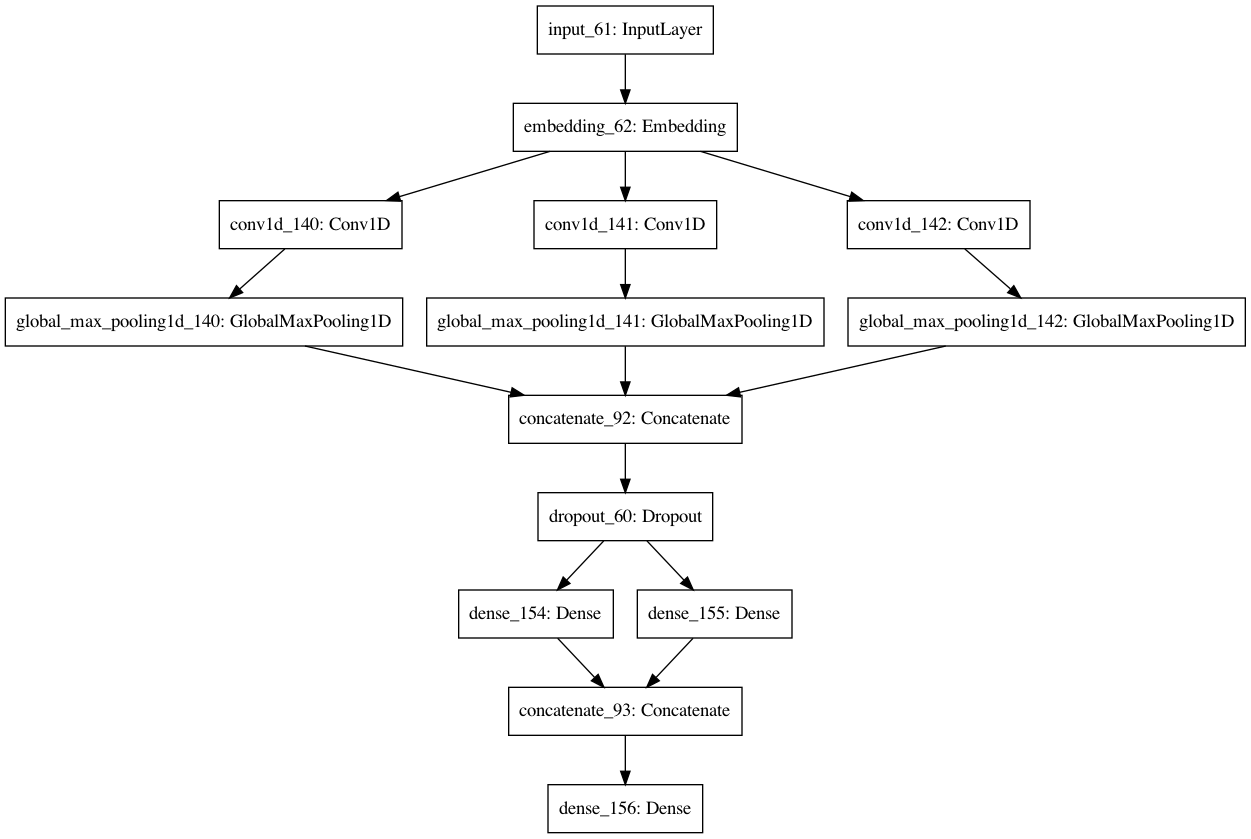

In [154]:
keras.utils.plot_model(model)

In [155]:
model.summary()

Model: "functional_117"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_62 (Embedding)        (None, 100, 100)     661800      input_61[0][0]                   
__________________________________________________________________________________________________
conv1d_140 (Conv1D)             (None, 94, 12)       8412        embedding_62[0][0]               
__________________________________________________________________________________________________
conv1d_141 (Conv1D)             (None, 92, 40)       36040       embedding_62[0][0]               
_____________________________________________________________________________________

In [156]:
print(classification_report(test_labels, y_pred_bool, digits = 3, target_names = emotions))

              precision    recall  f1-score   support

       anger      0.442     0.279     0.342       775
anticipation      0.445     0.226     0.300       633
     disgust      0.431     0.163     0.237       460
        fear      0.368     0.148     0.211       500
         joy      0.624     0.404     0.490       592
     sadness      0.437     0.254     0.322       464
    surprise      0.409     0.071     0.121       505
       trust      0.420     0.149     0.220       564

   micro avg      0.463     0.219     0.298      4493
   macro avg      0.447     0.212     0.280      4493
weighted avg      0.450     0.219     0.288      4493
 samples avg      0.265     0.236     0.241      4493



/Users/charagon/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [157]:
from sklearn.metrics import accuracy_score, hamming_loss

def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

print('accuracy_score', accuracy_score(y_pred_bool, test_labels))
print('hamming loss  ', hamming_loss(y_pred_bool, test_labels))
print('hamming score ', hamming_score(test_labels, y_pred_bool))

accuracy_score 0.1814033086138049
hamming loss   0.16575156873930405
hamming score  0.22553717436775053


## Train an RNN (LSTM)

In [128]:
# LSTM model parameters
epochs = 10
embed_dim = 100
dropout_rate = 0.7
num_classes = 8

# Input is a special "layer".  It defines a placeholder that will be overwritten by the training data.
# In our case, we are accepting a list of wordids (padded out to max_len).
wordids = keras.layers.Input(shape=(max_len_touse,))

# Embed the wordids.
# Recall, this is just a mathematically equivalent operation to a linear layer and a one-hot
h = keras.layers.Embedding(len(tokenizer.word_index) + 1, embed_dim, input_length=max_len_touse)(wordids)

# Add LSTM
h = keras.layers.LSTM(64)(h)

# Dropout can help with overfitting (improve generalization) by randomly 0-ing different subsets of values
# in the vector.
# See https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf for details.
h = keras.layers.Dropout(rate=dropout_rate)(h)

prediction = keras.layers.Dense(num_classes, activation='sigmoid')(h)

model = keras.Model(inputs=wordids, outputs=prediction)
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',  # From information theory notebooks.
              metrics=['accuracy'])        # What metric to output as we train.
model.fit(train_padded, train_labels, epochs=epochs, validation_data=(dev_padded, dev_labels))
model.evaluate(test_padded, test_labels)

# Get F1 score
y_pred = model.predict(test_padded)
y_pred_bool = (y_pred>0.5)*1  # because last layer was sigmoid
print('F1 score: ', f1_score(test_labels, y_pred_bool, average='micro'))

Model: "functional_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_47 (Embedding)     (None, 100, 100)          661800    
_________________________________________________________________
dropout_45 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_129 (Dense)            (None, 8)                 520       
Total params: 704,560
Trainable params: 704,560
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
329/329 [==============================] - 14s 43ms/step - loss: 0.4464 - accuracy: 0.2048 - val_loss:

### Bidirection LSTM

In [129]:
# LSTM model parameters
epochs = 10
embed_dim = 100
dropout_rate = 0.7
num_classes = 8

# Input is a special "layer".  It defines a placeholder that will be overwritten by the training data.
# In our case, we are accepting a list of wordids (padded out to max_len).
wordids = keras.layers.Input(shape=(max_len_touse,))

# Embed the wordids.
# Recall, this is just a mathematically equivalent operation to a linear layer and a one-hot
h = keras.layers.Embedding(len(tokenizer.word_index) + 1, embed_dim, input_length=max_len_touse)(wordids)

# Add a bidirectional LSTMs
h = keras.layers.Bidirectional(keras.layers.LSTM(64))(h)

# Dropout can help with overfitting (improve generalization) by randomly 0-ing different subsets of values
# in the vector.
# See https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf for details.
h = keras.layers.Dropout(rate=dropout_rate)(h)

prediction = keras.layers.Dense(num_classes, activation='sigmoid')(h)

model = keras.Model(inputs=wordids, outputs=prediction)
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',  # From information theory notebooks.
              metrics=['accuracy'])        # What metric to output as we train.
model.fit(train_padded, train_labels, epochs=epochs, validation_data=(dev_padded, dev_labels))
model.evaluate(test_padded, test_labels)

# Get F1 score
y_pred = model.predict(test_padded)
y_pred_bool = (y_pred>0.5)*1  # because last layer was sigmoid
print('F1 score: ', f1_score(test_labels, y_pred_bool, average='micro'))

Model: "functional_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_48 (Embedding)     (None, 100, 100)          661800    
_________________________________________________________________
dropout_46 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_130 (Dense)            (None, 8)                 1032      
Total params: 747,312
Trainable params: 747,312
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
329/329 [==============================] - 19s 57ms/step - loss: 0.4438 - accuracy: 0.2129 - val_loss:

In [130]:
# LSTM model parameters
epochs = 10
embed_dim = 100
dropout_rate = 0.7
num_classes = 8

# Input is a special "layer".  It defines a placeholder that will be overwritten by the training data.
# In our case, we are accepting a list of wordids (padded out to max_len).
wordids = keras.layers.Input(shape=(max_len_touse,))

# Embed the wordids.
# Recall, this is just a mathematically equivalent operation to a linear layer and a one-hot
h = keras.layers.Embedding(len(tokenizer.word_index) + 1, embed_dim, input_length=max_len_touse)(wordids)

# Add 2 bidirectional LSTMs
h = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True))(h)
h = keras.layers.Bidirectional(keras.layers.LSTM(64))(h)

# Dropout can help with overfitting (improve generalization) by randomly 0-ing different subsets of values
# in the vector.
# See https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf for details.
h = keras.layers.Dropout(rate=dropout_rate)(h)

prediction = keras.layers.Dense(num_classes, activation='sigmoid')(h)

model = keras.Model(inputs=wordids, outputs=prediction)
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',  # From information theory notebooks.
              metrics=['accuracy'])        # What metric to output as we train.
model.fit(train_padded, train_labels, epochs=epochs, validation_data=(dev_padded, dev_labels))
model.evaluate(test_padded, test_labels)

# Get F1 score
y_pred = model.predict(test_padded)
y_pred_bool = (y_pred>0.5)*1  # because last layer was sigmoid
print('F1 score: ', f1_score(test_labels, y_pred_bool, average='micro'))

Model: "functional_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_49 (Embedding)     (None, 100, 100)          661800    
_________________________________________________________________
dropout_47 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100, 128)          84480     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_131 (Dense)            (None, 8)                 1032      
Total params: 846,128
Trainable params: 846,128
Non-trainable params: 0
_______________________________________________

### Tuning Hyperparameter using Random Search

In [159]:
for _ in range(5):
    # LSTM model parameters
    epochs = rn.randint(5, 25)
    embed_dim = 100
    dropout_rate = 0.7
    num_classes = 8

    # Input is a special "layer".  It defines a placeholder that will be overwritten by the training data.
    # In our case, we are accepting a list of wordids (padded out to max_len).
    wordids = keras.layers.Input(shape=(max_len_touse,))

    # Embed the wordids.
    # Recall, this is just a mathematically equivalent operation to a linear layer and a one-hot
    h = keras.layers.Embedding(len(tokenizer.word_index) + 1, embed_dim, input_length=max_len_touse)(wordids)

    # Add 2 bidirectional LSTMs
    h = keras.layers.Bidirectional(keras.layers.LSTM(64))(h)

    prediction = keras.layers.Dense(num_classes, activation='sigmoid')(h)

    # Dropout can help with overfitting (improve generalization) by randomly 0-ing different subsets of values
    # in the vector.
    # See https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf for details.
    h = keras.layers.Dropout(rate=dropout_rate)(h)
    
    model = keras.Model(inputs=wordids, outputs=prediction)
    model.summary()

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',  # From information theory notebooks.
                  metrics=['accuracy'])        # What metric to output as we train.
    model.fit(train_padded, train_labels, epochs=epochs, validation_data=(dev_padded, dev_labels))
    model.evaluate(test_padded, test_labels)

    # Get F1 score
    y_pred = model.predict(test_padded)
    y_pred_bool = (y_pred>0.5)*1  # because last layer was sigmoid
    print('F1 score: ', f1_score(test_labels, y_pred_bool, average='micro'))

Model: "functional_129"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_67 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_68 (Embedding)     (None, 100, 100)          661800    
_________________________________________________________________
dropout_66 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 128)               84480     
_________________________________________________________________
dense_162 (Dense)            (None, 8)                 1032      
Total params: 747,312
Trainable params: 747,312
Non-trainable params: 0
_________________________________________________________________
Epoch 1/16
329/329 [==============================] - 24s 73ms/step - loss: 0.4440 - accuracy: 0.2097 - val_loss

329/329 [==============================] - 23s 69ms/step - loss: 0.4436 - accuracy: 0.2180 - val_loss: 0.4275 - val_accuracy: 0.2658
Epoch 2/5
329/329 [==============================] - 25s 77ms/step - loss: 0.4118 - accuracy: 0.3053 - val_loss: 0.3980 - val_accuracy: 0.3371
Epoch 3/5
329/329 [==============================] - 35s 107ms/step - loss: 0.3815 - accuracy: 0.3819 - val_loss: 0.3888 - val_accuracy: 0.3525
Epoch 4/5
329/329 [==============================] - 22s 67ms/step - loss: 0.3603 - accuracy: 0.4302 - val_loss: 0.3792 - val_accuracy: 0.3776
Epoch 5/5
110/110 [==============================] - 1s 10ms/step - loss: 0.3831 - accuracy: 0.3736
F1 score:  0.2738361106339117
Model: "functional_135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_70 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_71 (Embed

In [168]:
# LSTM model parameters
epochs = 10
embed_dim = 100
dropout_rate = 0.7
num_classes = 8

# Input is a special "layer".  It defines a placeholder that will be overwritten by the training data.
# In our case, we are accepting a list of wordids (padded out to max_len).
wordids = keras.layers.Input(shape=(max_len_touse,))

# Embed the wordids.
# Recall, this is just a mathematically equivalent operation to a linear layer and a one-hot
h = keras.layers.Embedding(len(tokenizer.word_index) + 1, embed_dim, input_length=max_len_touse)(wordids)

# Add a bidirectional LSTMs
h = keras.layers.Bidirectional(keras.layers.LSTM(64))(h)

# h = keras.layers.Dense(dense_size, activation='relu')(h)

# Dropout can help with overfitting (improve generalization) by randomly 0-ing different subsets of values
# in the vector.
# See https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf for details.
h = keras.layers.Dropout(rate=dropout_rate)(h)

prediction = keras.layers.Dense(num_classes, activation='sigmoid')(h)

model = keras.Model(inputs=wordids, outputs=prediction)
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',  # From information theory notebooks.
              metrics=['accuracy'])        # What metric to output as we train.
model.fit(train_padded, train_labels, epochs=epochs, validation_data=(dev_padded, dev_labels))
model.evaluate(test_padded, test_labels)

# Get F1 score
y_pred = model.predict(test_padded)
y_pred_bool = (y_pred>0.5)*1  # because last layer was sigmoid
print('F1 score: ', f1_score(test_labels, y_pred_bool, average='micro'))

Model: "functional_151"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_79 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_80 (Embedding)     (None, 100, 100)          661800    
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 128)               84480     
_________________________________________________________________
dropout_77 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_179 (Dense)            (None, 8)                 1032      
Total params: 747,312
Trainable params: 747,312
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
329/329 [==============================] - 13s 40ms/step - loss: 0.4589 - accuracy: 0.1769 - val_loss

In [169]:
print(classification_report(test_labels, y_pred_bool, digits = 3, target_names = emotions))
print('hamming score ', hamming_score(test_labels, y_pred_bool))

              precision    recall  f1-score   support

       anger      0.457     0.382     0.416       775
anticipation      0.438     0.272     0.335       633
     disgust      0.435     0.159     0.232       460
        fear      0.446     0.150     0.225       500
         joy      0.612     0.429     0.504       592
     sadness      0.458     0.198     0.277       464
    surprise      0.378     0.145     0.209       505
       trust      0.440     0.213     0.287       564

   micro avg      0.470     0.257     0.332      4493
   macro avg      0.458     0.243     0.311      4493
weighted avg      0.460     0.257     0.322      4493
 samples avg      0.307     0.278     0.282      4493

hamming score  0.26286841604867844


In [170]:
# LSTM model parameters
epochs = 10
embed_dim = 100
dropout_rate = 0.5
num_classes = 8

# Input is a special "layer".  It defines a placeholder that will be overwritten by the training data.
# In our case, we are accepting a list of wordids (padded out to max_len).
wordids = keras.layers.Input(shape=(max_len_touse,))

# Embed the wordids.
# Recall, this is just a mathematically equivalent operation to a linear layer and a one-hot
h = keras.layers.Embedding(len(tokenizer.word_index) + 1, embed_dim, input_length=max_len_touse)(wordids)

# Add a bidirectional LSTMs
h = keras.layers.Bidirectional(keras.layers.LSTM(64))(h)

# h = keras.layers.Dense(dense_size, activation='relu')(h)

# Dropout can help with overfitting (improve generalization) by randomly 0-ing different subsets of values
# in the vector.
# See https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf for details.
h = keras.layers.Dropout(rate=dropout_rate)(h)

prediction = keras.layers.Dense(num_classes, activation='sigmoid')(h)

model = keras.Model(inputs=wordids, outputs=prediction)
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',  # From information theory notebooks.
              metrics=['accuracy'])        # What metric to output as we train.
model.fit(train_padded, train_labels, epochs=epochs, validation_data=(dev_padded, dev_labels))
model.evaluate(test_padded, test_labels)

# Get F1 score
y_pred = model.predict(test_padded)
y_pred_bool = (y_pred>0.5)*1  # because last layer was sigmoid
print('F1 score: ', f1_score(test_labels, y_pred_bool, average='micro'))

Model: "functional_153"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_80 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_81 (Embedding)     (None, 100, 100)          661800    
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 128)               84480     
_________________________________________________________________
dropout_78 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_180 (Dense)            (None, 8)                 1032      
Total params: 747,312
Trainable params: 747,312
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
329/329 [==============================] - 13s 40ms/step - loss: 0.4516 - accuracy: 0.1886 - val_loss

In [171]:
print(classification_report(test_labels, y_pred_bool, digits = 3, target_names = emotions))
print('hamming score ', hamming_score(test_labels, y_pred_bool))

              precision    recall  f1-score   support

       anger      0.498     0.290     0.367       775
anticipation      0.400     0.321     0.356       633
     disgust      0.364     0.146     0.208       460
        fear      0.439     0.202     0.277       500
         joy      0.538     0.473     0.504       592
     sadness      0.413     0.267     0.325       464
    surprise      0.367     0.200     0.259       505
       trust      0.451     0.230     0.305       564

   micro avg      0.447     0.274     0.340      4493
   macro avg      0.434     0.266     0.325      4493
weighted avg      0.440     0.274     0.333      4493
 samples avg      0.323     0.293     0.297      4493

hamming score  0.27573683209735694


In [172]:
# LSTM model parameters
epochs = 12
embed_dim = 100
dropout_rate = 0.7
num_classes = 8

# Input is a special "layer".  It defines a placeholder that will be overwritten by the training data.
# In our case, we are accepting a list of wordids (padded out to max_len).
wordids = keras.layers.Input(shape=(max_len_touse,))

# Embed the wordids.
# Recall, this is just a mathematically equivalent operation to a linear layer and a one-hot
h = keras.layers.Embedding(len(tokenizer.word_index) + 1, embed_dim, input_length=max_len_touse)(wordids)

# Add a bidirectional LSTMs
h = keras.layers.Bidirectional(keras.layers.LSTM(64))(h)

# h = keras.layers.Dense(dense_size, activation='relu')(h)

# Dropout can help with overfitting (improve generalization) by randomly 0-ing different subsets of values
# in the vector.
# See https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf for details.
h = keras.layers.Dropout(rate=dropout_rate)(h)

prediction = keras.layers.Dense(num_classes, activation='sigmoid')(h)

model = keras.Model(inputs=wordids, outputs=prediction)
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',  # From information theory notebooks.
              metrics=['accuracy'])        # What metric to output as we train.
model.fit(train_padded, train_labels, epochs=epochs, validation_data=(dev_padded, dev_labels))
model.evaluate(test_padded, test_labels)

# Get F1 score
y_pred = model.predict(test_padded)
y_pred_bool = (y_pred>0.5)*1  # because last layer was sigmoid
print('F1 score: ', f1_score(test_labels, y_pred_bool, average='micro'))

Model: "functional_155"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_81 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_82 (Embedding)     (None, 100, 100)          661800    
_________________________________________________________________
bidirectional_30 (Bidirectio (None, 128)               84480     
_________________________________________________________________
dropout_79 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_181 (Dense)            (None, 8)                 1032      
Total params: 747,312
Trainable params: 747,312
Non-trainable params: 0
_________________________________________________________________
Epoch 1/12
329/329 [==============================] - 37s 112ms/step - loss: 0.4594 - accuracy: 0.1728 - val_los

In [173]:
print(classification_report(test_labels, y_pred_bool, digits = 3, target_names = emotions))
print('hamming score ', hamming_score(test_labels, y_pred_bool))

              precision    recall  f1-score   support

       anger      0.533     0.285     0.371       775
anticipation      0.427     0.284     0.341       633
     disgust      0.424     0.193     0.266       460
        fear      0.384     0.172     0.238       500
         joy      0.574     0.389     0.463       592
     sadness      0.422     0.235     0.302       464
    surprise      0.354     0.123     0.182       505
       trust      0.423     0.184     0.257       564

   micro avg      0.460     0.241     0.316      4493
   macro avg      0.442     0.233     0.303      4493
weighted avg      0.450     0.241     0.311      4493
 samples avg      0.293     0.257     0.265      4493

hamming score  0.24713348545350827
